# 🖐️ Finger Gestures Detection using YOLOv8
This notebook implements finger gesture detection (numbers 0 to 5) using YOLOv8.
---

# 📂 1️⃣ Dataset Preparation
- Download and merge datasets
- Organize into `images` and `labels`
- Split into `train`, `val`, `test` using `split-folders`

In [ ]:
!pip install ultralytics # 📦 Install the Ultralytics library, which includes YOLOv8 and related tools

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Datasets" # Change this to your local path or Google Drive mount path if running in Colab !!!

In [ ]:
# Install Roboflow package
!pip install roboflow

from roboflow import Roboflow

# Replace YOUR_API_KEY with your actual API key( you will find it in your roboflow profil settings )
rf = Roboflow(api_key="YOUR_API_KEY")

# Access to the dataset
project = rf.workspace("hands-rirpj").project("fingers-numbers")

# Loop over versions 1 to 7 and download YOLOv8 format
for i in range(1, 8):
    print(f"Downloading dataset version {i} ...")
    dataset = project.version(i).download("yolov8", location=f"{DATA_DIR}/fingers_dataset_v{i}")
    print(f"✅ Dataset v{i} downloaded and extracted to {DATA_DIR}/fingers_dataset_v{i}")

In [ ]:
import os
import shutil

def merge_all_data(versions_paths, merged_dir):
    # 📁 Create output folders for merged images and labels
    os.makedirs(os.path.join(merged_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(merged_dir, "labels"), exist_ok=True)

    # 🔄 Loop over each dataset version
    for v_idx, v_path in enumerate(versions_paths, 1):
        # Loop over both 'train' and 'test' splits
        for split in ["train", "test"]:
            img_dir = os.path.join(v_path, split, "images")
            lbl_dir = os.path.join(v_path, split, "labels")

            # Skip if image directory doesn't exist
            if not os.path.exists(img_dir):
                continue

            # Iterate over all image files
            for img_file in os.listdir(img_dir):
                if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue  # Skip non-image files

                base_name, ext = os.path.splitext(img_file)
                label_file = base_name + ".txt"

                # 🏷 Rename to avoid conflicts between datasets
                new_img_name = f"{base_name}_v{v_idx}{ext}"
                new_lbl_name = f"{base_name}_v{v_idx}.txt"

                # 📥 Copy image to merged folder
                shutil.copy2(
                    os.path.join(img_dir, img_file),
                    os.path.join(merged_dir, "images", new_img_name)
                )

                # 📝 Copy corresponding label file if it exists
                lbl_src_path = os.path.join(lbl_dir, label_file)
                if os.path.exists(lbl_src_path):
                    shutil.copy2(
                        lbl_src_path,
                        os.path.join(merged_dir, "labels", new_lbl_name)
                    )
                else:
                    print(f"⚠ Warning: Label not found for {img_file} in version {v_idx} split {split}")

    print("✅ All data merged into one folder!")

# 🧪 Usage example:
versions = [f"{DATA_DIR}/fingers_dataset_v{i}" for i in range(1, 8)]
merged_output = f"{DATA_DIR}/fingers_dataset(merged)"
merge_all_data(versions, merged_output)

✅ All data merged into one folder!


Once you merged the data , you have to create **data.yaml** file for your dataset folder

In [ ]:
data_yaml_content = f"""
nc: 6
names:
  - '0'
  - '1'
  - '2'
  - '3'
  - '4'
  - '5'

train: {DATA_DIR}/fingers_dataset(split)/train/images
val: {DATA_DIR}/fingers_dataset(split)/val/images
test: {DATA_DIR}/fingers_dataset(split)/test/images
"""

with open("/data/fingers_dataset(split)/data.yaml", "w") as f:
    f.write(data_yaml_content.strip())

print("✅ data.yaml file created!")


✅ data.yaml file created!


In [ ]:
# 📦 Install the split-folders library used to split datasets into train/val/test sets
!pip install split-folders

import splitfolders

# 📁 Define input and output paths
input_folder = f"{DATA_DIR}/fingers_dataset(merged)"
output_folder = f"{DATA_DIR}/fingers_dataset(split)"

splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.7, 0.2, 0.1),    # 🔀 Split dataset into 70% train, 20% val, 10% test
    group_prefix=None         # Automatically group images and labels by filename
)

print("✅ Dataset split into train/val/test folders!")

# 📊 2️⃣ Data Visualization
- Show class distribution with bar plots (Seaborn / Matplotlib)
- Display random training samples

Class Distribution shows how many objects of each class (0 to 5) are present in the training labels.  
It helps check for class imbalance — which can affect model performance.The output should be like this :

![Sans titre.png](<attachment:Sans titre.png>)
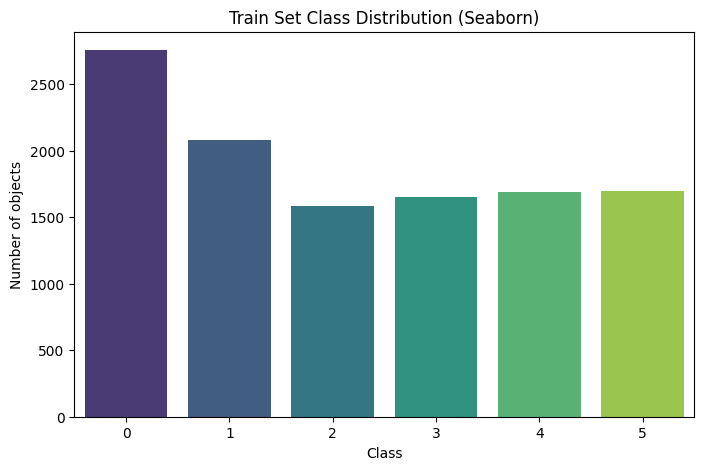

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your train labels folder
labels_path = f'{DATA_DIR}/fingers_dataset(split)/train/labels'

# Initialize counts for each class (assuming 6 classes: 0 to 5)
class_counts = {str(i): 0 for i in range(6)}

# Loop through label files
for label_file in os.listdir(labels_path):
    if label_file.endswith('.txt'):
        with open(os.path.join(labels_path, label_file), 'r') as f:
            for line in f:
                cls = line.strip().split()[0]
                if cls in class_counts:
                    class_counts[cls] += 1
                else:
                    class_counts[cls] = 1  # Just in case there's an unexpected class


# Prepare data for seaborn
classes = list(class_counts.keys())
counts = [class_counts[cls] for cls in classes]

# Plot using seaborn
plt.figure(figsize=(8,5))
sns.barplot(x=classes, y=counts, palette="viridis")

plt.xlabel("Class")
plt.ylabel("Number of objects")
plt.title("Train Set Class Distribution (Seaborn)")
plt.show()

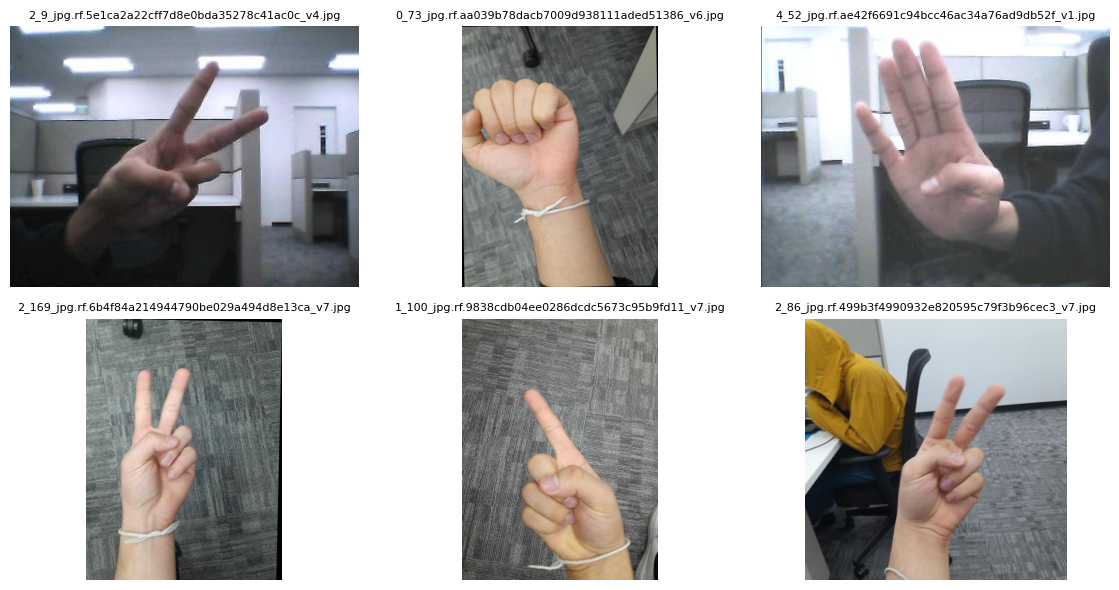

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your training images
train_img_dir = f'{DATA_DIR}/fingers_dataset(split)/train/images'

# List image files
img_files = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Pick 6 random images
sample_imgs = random.sample(img_files, 6)

# Plot them
plt.figure(figsize=(12, 6))

for i, img_file in enumerate(sample_imgs):
    img_path = os.path.join(train_img_dir, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(img_file, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 🏋️‍♂️ 3️⃣ Model Training
- Initialize YOLOv8 model
- Train with defined parameters (imgsz, batch, epochs)
- Save best and periodic checkpoints

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLOv8n model (nano version - lightweight and fast)
model = YOLO('yolov8n.pt')

# Train the model with specified parameters
model.train(
    data= f'{DATA_DIR}/fingers_dataset(split)/data.yaml',  # Path to dataset config file
    epochs=50,      # Number of training epochs
    imgsz=416,      # Input image size (416x416)
    batch=32,       # Batch size
    name='fingers_yolo_model'  # Name for this training run
)

# Note:
# During training, YOLO automatically creates a 'runs' folder in your working directory.
# This folder stores weights, logs, and results for each training run,
# organized under subfolders named after the 'name' parameter above.


# 📈 4️⃣ Evaluation and Metrics
- Plot training history (losses, mAP, precision, recall)
- Show confusion matrix
- Display example predictions

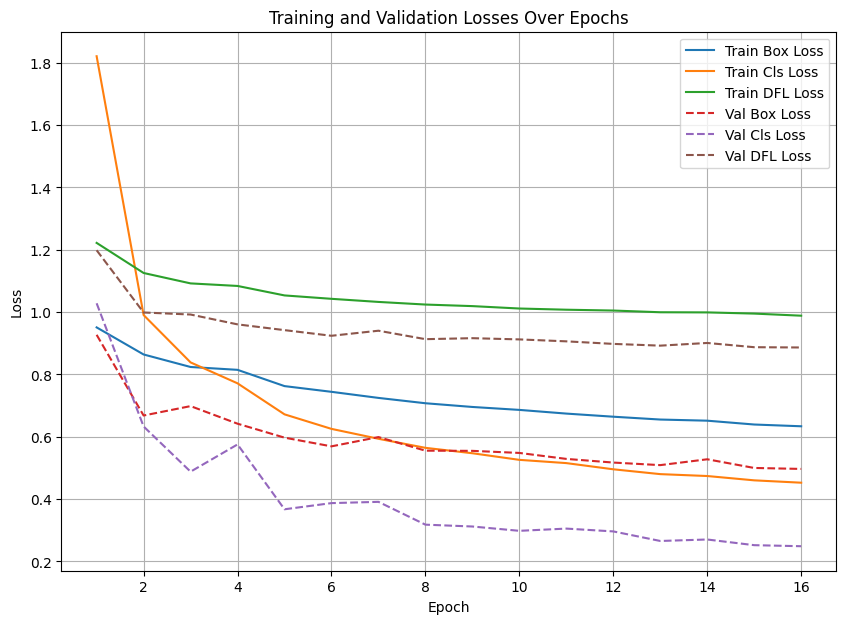

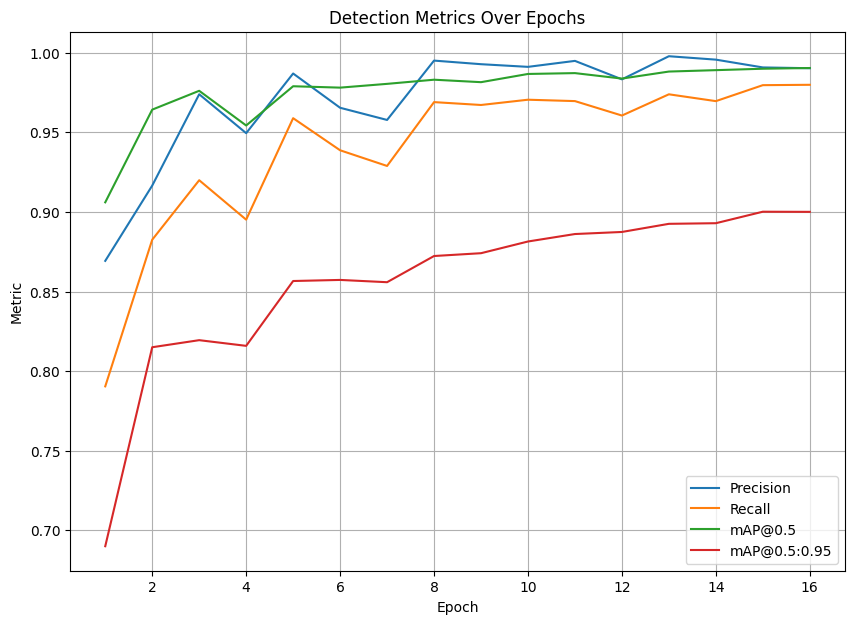

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV file
df = pd.read_csv('/runs/detect/fingers_yolo_model/results.csv')


# Example: plot losses and mAP over epochs if those columns exist


plt.figure(figsize=(10, 7))

# Plot training losses
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')

# Plot validation losses
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', linestyle='--')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', linestyle='--')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot precision, recall, and mAP

plt.figure(figsize=(10, 7))

plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Detection Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from ultralytics import YOLO

# 🧠 Load the best trained YOLOv8 model from saved weights
model = YOLO('runs/detect/fingers_yolo_model/weights/best.pt')

# 🧪 Evaluate the model on the test set defined in the data.yaml file
results = model.val(
    data = f'{DATA_DIR}/fingers_dataset(split)/data.yaml',
    split = "test" # The 'split="test"' argument ensures evaluation uses the test subset
)


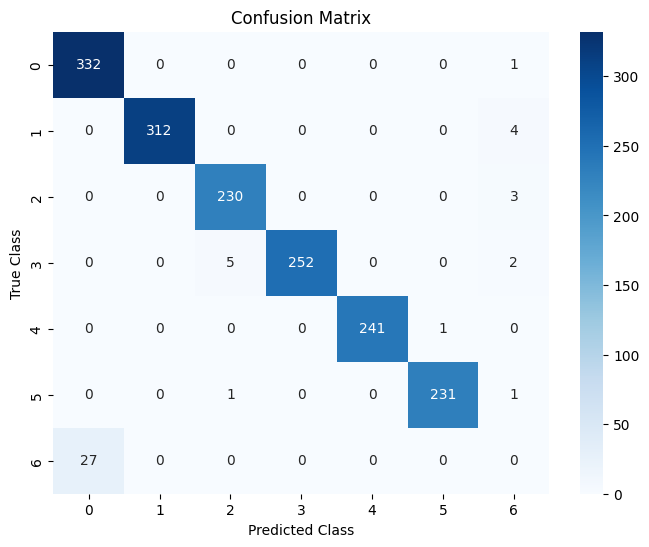

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = results.confusion_matrix.matrix  # get the numpy array from the object

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Note:
# Our dataset has 6 classes (labeled 0 to 5).
# However, the Ultralytics ConfusionMatrix object includes an additional row and column, resulting in a 7×7 matrix.
# This extra class corresponds to the background or no-detection category,
# which accounts for predictions where no object is detected.

In [ ]:
# 📌 Use the trained YOLOv8 model to make predictions on the test images
# ✅ 'save=True' saves prediction images with bounding boxes to 'runs/detect/predict'

results = model.predict(source = f"{DATA_DIR}/fingers_dataset(split)/test/images", save=True)

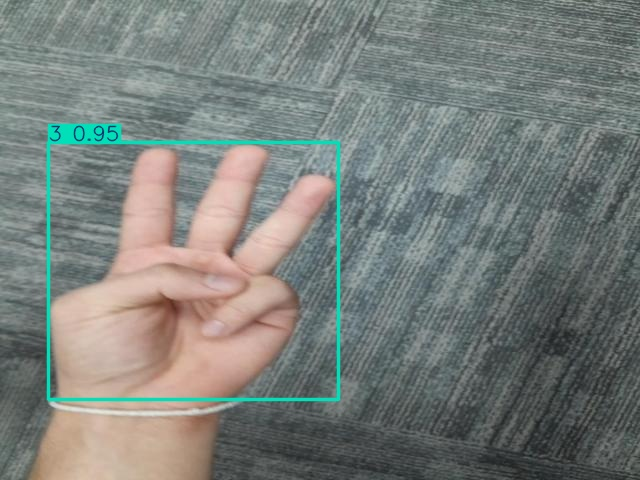

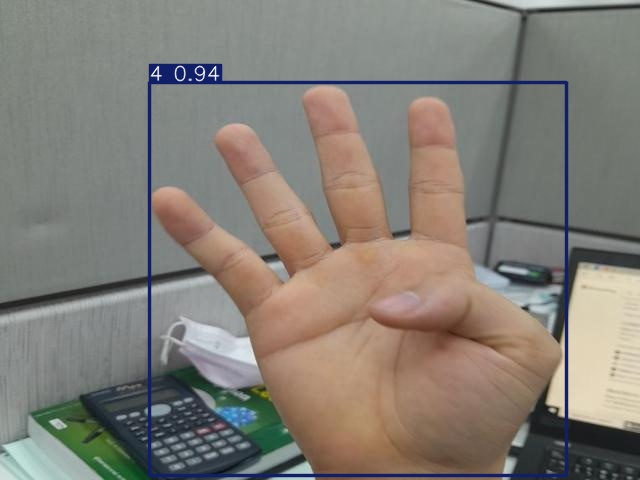

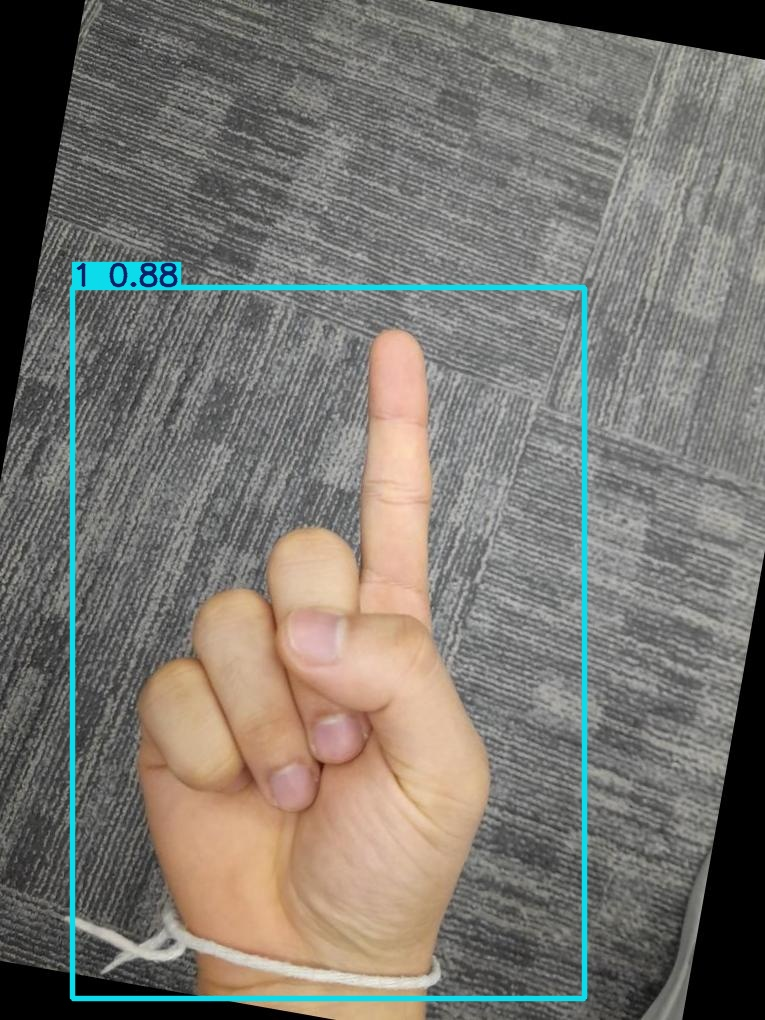

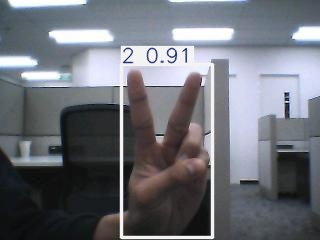

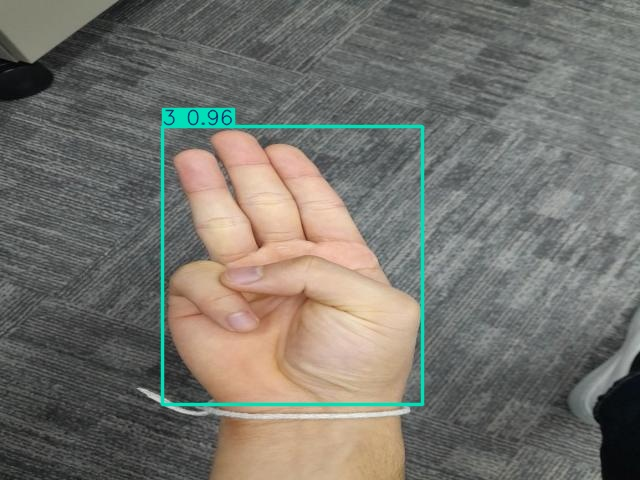

In [ ]:
from IPython.display import Image, display
import glob

# Get list of saved predicted images
predicted_images = glob.glob('runs/detect/predict/*.jpg')

# Display a few
for img_path in predicted_images[:5]:  # show first 5 predictions
    display(Image(filename=img_path, width=400, height=300))

# 📎 References
- [Ultralytics YOLOv8](https://github.com/ultralytics/ultralytics)
- [Roboflow](https://roboflow.com)